#  PoC Report - Bike Sharing Demand for NYC Citi Bike

A work of ***dataslays*** - your trustful partner for data science projects

<div class="alert alert-block alert-info">

Hello, I'm My, the data scientist at Dataslays responsible for this project.

In this notebook, I will guide you through the complete data science Proof of Concept (PoC), emphasizing how Machine Learning can serve as a viable solution for your problem. You can expect detailed explanations to enhance your understanding of the underlying methodology, particularly if you're interested in exploring the technical aspects deeply.

</div>

### **Table of Contents**

[1. Context](#1-context)

[2. The Data](#2-the-data)

[3. Initial Data Analysis](#3-initial-data-analysis)

[4. EDA and Preprocessing](#4-eda-and-preprocessing)

[5. First Impressions](#5-first-impressions)

[6. Hyperparameter Optimization – Nested Cross Validation](#6-hyperparameter-optimization---nested-cross-validation)

[7. Feature Importance / Feature Ablation Study](#7-feature-importance-/-feature-ablation-study)

[8. Conclusions and Future Work](#8-conclusions-and-future-work)

# 0. Imports and Functions

## 0.1. Imports

In [1]:
# !pip install holidays

In this PoC, Python was used as programming language with these main packages.

In [2]:
import pandas as pd  # Data manipulation
import numpy as np  # Numerical arrays
import matplotlib.pyplot as plt  # Data plotting
import seaborn as sns  # Enhanced visualizations

pd.options.display.max_columns = None

import glob
import os
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

import sklearn 

# To ensure the reproducibility of the experiment
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Additional packages will be introduced in later sections as needed.

## 0.2. Functions

In [3]:
def display_model_results_table(model_results, baseline_mae, baseline_r2, 
                               model_groups=None, add_separators=True):
    
    """
    Displays a formatted table of model performance results, comparing against a baseline.

    Args:
        model_results (dict): Dictionary containing model names as keys and their
                              MAE and R^2 scores (train/test) as values.
        baseline_mae (float): Test MAE of the baseline model for comparison.
        baseline_r2 (float): Test R^2 of the baseline model for comparison.
        model_groups (list of lists, optional): Groups models for display with separators.
        add_separators (bool, optional): If True, adds separators between model groups.
    """

    print(f"{'Model':<32} {'Train MAE':>12} {'Test MAE':>12} {'ΔMAE (Test)':>15} {'Train R²':>12} {'Test R²':>12} {'ΔR² (Test)':>15}")
    print("=" * 116)

    def print_model_row(model_name, results):
        # Calculate percentage change from baseline for MAE and R2
        if model_name == 'Hourly Average Baseline':
            mae_change_str = "-"
            r2_change_str = "-"
        else:
            mae_change_pct = (-(results['mae_test'] - baseline_mae) / baseline_mae) * 100
            r2_change_pct = ((results['r2_test'] - baseline_r2) / baseline_r2) * 100 if baseline_r2 != 0 else 0
            mae_change_str = f"{mae_change_pct:>12.1f} %"
            r2_change_str = f"{r2_change_pct:>12.1f} %"

        mae_train_str = f"{results['mae_train']:>5.0f}" if results['mae_train'] is not None else "-"
        r2_train_str = f"{results['r2_train']:>10.3f}" if results['r2_train'] is not None else "-"

        print(f"{model_name:<32} "
              f"{mae_train_str:>12} "
              f"{results['mae_test']:>12.0f} "
              f"{mae_change_str:>15} "
              f"{r2_train_str:>12} "
              f"{results['r2_test']:>12.3f} "
              f"{r2_change_str:>15}")
    
    if model_groups and add_separators:
        for i, group in enumerate(model_groups):

            if i > 0:
                print("-" * 116)
            
            for model_name in group:
                if model_name in model_results:
                    print_model_row(model_name, model_results[model_name])
    else:
        for model_name, results in model_results.items():
            print_model_row(model_name, results)

# 1. Context

## 1.1. Client requirements and expectations

> **WHY?**

Citi Bike, operated by Motivate (a subsidiary of Lyft), is the largest bike sharing system in New York City, serving millions of residents and visitors each year. The network consists of thousands of bikes and hundreds of docking stations distributed across Manhattan, Brooklyn, Queens, and Jersey City. Citi Bike offers both classic pedal bikes and electric bikes, enabling flexible, eco-friendly transportation throughout the city. The system faces the ongoing challenge of matching bike supply with demand, especially during peak commuting hours and special events.

The rapid growth of urban mobility solutions has made bike sharing a critical component of New York City's transportation ecosystem. However, unpredictable demand patterns lead to operational inefficiencies, such as bike shortages at popular stations and excess bikes at others. This results in customer dissatisfaction and increased operational costs for Citi Bike. Accurately forecasting bike rental demand is essential for optimizing bike redistribution, improving user experience, and reducing costs.

Previous research has demonstrated the effectiveness of machine learning approaches for bike demand forecasting in other major cities.  For example, Sathishkumar et al. ("Using data mining techniques for bike sharing demand prediction in metropolitan city," Department of Information and Communication Engineering, Sunchon National University, South Korea) successfully applied machine learning models to predict demand in the Seoul bike sharing system, highlighting the potential of such methods to capture complex temporal and environmental patterns in urban mobility data.

> **WHEN?**

The project pitch was successfully conducted on May 12, 2025, with results expected to be presented on June 30, 2025.

> **WHO?**

Your company has selected ***dataslays*** as your partner for executing this project. With over five years of experience assisting multiple companies on their data science journey, we are committed to ensuring success.

> **WHAT?**

The ultimate goal is to develop a machine learning-based system that predicts hourly bike rental demand at Citi Bike stations across NYC. The system will:

* Ingest and preprocess historical bike rental and weather data.
* Engineer relevant features (e.g., time, weather, holidays, seasonality).
* Train and evaluate **regression models** to forecast demand.
* Provide actionable insights for operational planning and resource allocation.

For the purpose of this PoC, we focus on predicting the hourly demand for classic bikes (excluding electric bikes) aggregated across all stations in NYC. This scope enables us to develop and validate a robust modeling pipeline, before extend to to station-level or bike-type-specific forecasts. 

The preliminary results will serve as a foundation for further refinement and potential integration into Citi Bike's operational systems. The PoC model can then be directly implemented within the operational environment to further test its performance in specific projects or campaigns. For example, it could enable real-time discount offers during periods of low demand for classic bikes, supporting dynamic pricing strategies and targeted marketing initiatives to boost usage.

> **HOW?**

The dataset used is a real-world collection of NYC Citi Bike trip records, enriched with weather and calendar data. This dataset is suitable for regression modeling and allows for robust experimentation (see Chapter 2 for details).

The PoC addresses these essential components:

- Data Acquisition (Assembly notebook, Chapters 2, 3)
- Sub-task Selection (Hourly demand prediction of classic bike)
- Exploratory Data Analysis (EDA) (Chapter 4)
- Solution Modeling (Chapters 5, 6, 7)
- Preliminary Results and Insights (Chapter 7, 8)

## 1.2. Quality criteria for model evaluation

For this PoC, we focus on two main quality criteria:

- **Mean Absolute Error (MAE)**: Measures the average magnitude of errors in predictions, providing an interpretable metric in the same units as the target variable (number of bikes). MAE is robust to outliers and easy to communicate to stakeholders.

- **R² Score (Coefficient of Determination)**: Indicates the proportion of variance in the target variable explained by the model. R² provides a normalized measure of model performance, facilitating comparison between models.

These criteria are chosen because they are standard for regression tasks, are easy to interpret, and directly relate to the business value of accurate demand forecasting.

# 2. The Data

<div class="alert alert-block alert-info">

The dataset comprises historical Citi Bike trip records for classic bikes, which were assembled using a dedicated data assembly notebook (assembly.ipynb). These records were further enriched with hourly weather data retrieved from the Historical Weather API provided by open-meteo.com.

Both data sources are openly accessible and appropriately licensed for academic and non-commercial use. The Citi Bike trip data is available under the [CITI BIKE DATA LICENSE]('https://citibikenyc.com/system-data'), which permits redistribution and analysis for non-commercial purposes. The weather data, obtained from Open-meteo, is provided under the [CREATIVE COMMONS FOR NON-COMMERCIAL USE]('https://open-meteo.com/en/terms), allowing free use with proper attribution. For commercial or operational applications, the appropriate license for the weather data must be acquired from Open-meteo.

</div>

In [4]:
raw_data = pd.read_csv('data/raw_data.csv') #The raw_data.csv file is included in the submitted data/ directory
raw_data

date  hour  rented_bike_count  temperature  humidity  wind_speed  \
0     2024-01-01     0                432          1.7        74        1.75   
1     2024-01-01     1                583          1.7        76        2.46   
2     2024-01-01     2                519          2.7        74        3.16   
3     2024-01-01     3                272          2.8        74        2.69   
4     2024-01-01     4                142          2.6        76        2.25   
...          ...   ...                ...          ...       ...         ...   
8779  2024-12-31    20                442          8.1        81        2.96   
8780  2024-12-31    21                191          8.0        82        3.01   
8781  2024-12-31    22                 88          7.3        87        2.69   
8782  2024-12-31    23                213          7.3        91        3.39   
8783  2024-03-10     2                  0          9.7        97        2.11   

      dew_point  solar_radiation  rainfall  snowfall  cloud_cover  \
0          -2.4              0.0       0.0       0.0          100   
1          -2.2              0.0       0.0       0.0          100   
2          -1.5              0.0       0.0       0.0          100   
3          -1.3              0.0       0.0       0.0          100   
4          -1.2              0.0       0.0       0.0           65   
...         ...              ...       ...       ...          ...   
8779        5.1              0.0       0.0       0.0           98   
8780        5.0              0.0       0.0       0.0          100   
8781        5.4              0.0       3.1       0.0          100   
8782        5.9              0.0       2.8       0.0          100   
8783        9.3              0.0       0.0       0.0          100   

      apparent_temperature  wind_gusts  sunshine_duration  
0                     -1.6         3.6                0.0  
1                     -2.0         3.8                0.0  
2                     -1.3         5.1                0.0  
3                     -0.9         4.9                0.0  
4                     -0.8         4.2                0.0  
...                    ...         ...                ...  
8779                   5.3         7.2                0.0  
8780                   5.2         6.4                0.0  
8781                   4.8         6.5                0.0  
8782                   4.5         7.7                0.0  
8783                   8.5         6.6                0.0  

[8784 rows x 14 columns]

<div class="alert alert-block alert-info">
The final dataset contains 8,784 rows, each representing a single hour from January 1, 2024, to December 31, 2024. Every row reflects the total number of classic bikes rented per hour across all Citi Bike stations in New York City, along with 12 corresponding weather features, as detailed in Table 1.
</div>

Table 1: Features of raw data
| Column              | Description                                          | Type                     | Measurement      |
|:---------------------|:-----------------------------------------------------|:-------------------------|:-----------------|
| date                 | Calendar date of observation                         | date (year, month, day)  | 2024-01-01 to 2024-12-31   |
| hour                 | Hour of the day (24h format)                         | discrete | 0,1,2,...,23     |
| rented_bike_count    | Total number of classic bikes rented in the hour     | discrete          | 0,1,2,...        |
| temperature          | Air temperature at 2 meters above ground             | continuous               | °C               |
| humidity             | Relative humidity at 2 meters above ground           | continuous               | %                |
| wind_speed           | Wind speed at 10 meters above ground                 | continuous               | m/s              |
| dew_point            | Dew point temperature at 2 meters above ground       | continuous               | °C               |
| solar_radiation      | Shortwave solar radiation, average of preceding hour | continuous               | MJ/m²            |
| rainfall             | Rainfall (sum in preceding hour)                     | continuous               | mm               |
| snowfall             | Snowfall amount in the preceding hour                | continuous               | cm               |
| cloud_cover          | Total cloud cover as area fraction                   | continuous               | %                |
| apparent_temperature | Feels-like temperature (wind, humidity, radiation)   | continuous               | °C               |
| wind_gusts           | Maximum wind gusts at 10 meters in preceding hour    | continuous               | m/s              |
| sunshine_duration    | Duration of sunshine in the hour                     | continuous               | seconds (0-3600) |

<div class="alert alert-block alert-info">

The dataset is well-suited for this project for several reasons:

- It consists of real-world data generated directly from the operational Citi Bike system in New York City.

- The included features such as time, weather conditions, and soon added, calendar effects, are highly relevant for modeling and forecasting bike rental demand.

- The target variable, rented_bike_count, is a discrete count, making this a clear **regression** problem.

- With 8,784 hourly observations spanning an entire year, the dataset is sufficiently large and diverse to enable robust model training and reliable evaluation.

</div>

<div class="alert alert-block alert-info">
Now let's explore the data in more detail.
</div>

# 3. Initial Data Analysis

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  8784 non-null   object 
 1   hour                  8784 non-null   int64  
 2   rented_bike_count     8784 non-null   int64  
 3   temperature           8784 non-null   float64
 4   humidity              8784 non-null   int64  
 5   wind_speed            8784 non-null   float64
 6   dew_point             8784 non-null   float64
 7   solar_radiation       8784 non-null   float64
 8   rainfall              8784 non-null   float64
 9   snowfall              8784 non-null   float64
 10  cloud_cover           8784 non-null   int64  
 11  apparent_temperature  8784 non-null   float64
 12  wind_gusts            8784 non-null   float64
 13  sunshine_duration     8784 non-null   float64
dtypes: float64(9), int64(4), object(1)
memory usage: 960.9+ KB


In [6]:
raw_data.drop(columns=['hour']).describe().round(2)

rented_bike_count  temperature  humidity  wind_speed  dew_point  \
count            8784.00      8784.00   8784.00     8784.00    8784.00   
mean             1714.04        12.92     68.83        3.44       6.69   
std              1483.36         9.85     19.33        1.79       9.75   
min                 0.00       -15.00     15.00        0.00     -19.40   
25%               392.00         5.00     54.00        2.11      -0.50   
50%              1397.00        13.20     70.00        3.11       7.40   
75%              2664.25        21.10     86.00        4.46      14.40   
max              6945.00        36.20    100.00       15.92      24.70   

       solar_radiation  rainfall  snowfall  cloud_cover  apparent_temperature  \
count          8784.00   8784.00   8784.00      8784.00               8784.00   
mean            172.89      0.14      0.01        55.09                 11.07   
std             247.64      0.76      0.07        43.81                 12.12   
min               0.00      0.00      0.00         0.00                -19.20   
25%               0.00      0.00      0.00         3.00                  1.10   
50%               7.00      0.00      0.00        66.50                 10.70   
75%             314.00      0.00      0.00       100.00                 21.00   
max             957.00     17.30      2.38       100.00                 40.00   

       wind_gusts  sunshine_duration  
count     8784.00            8784.00  
mean         6.59            1281.58  
std          3.20            1676.71  
min          0.40               0.00  
25%          4.10               0.00  
50%          6.20               0.00  
75%          8.50            3600.00  
max         27.60            3600.00

<div class="alert alert-block alert-info">

Looking at the table above, we can observe some important, first insights:

* Target variable: The rented_bike_count showss substantial variability, with a mean of 1,714 rentals per hour (std: 1,483). The minimum recorded is 0, and the maximum is 6,945, indicating significant fluctuations in demand throughout the year and across different hours.

* Weather variables: 
    - The temperature ranges from -15.0°C to 36.2°C (mean: 12.9°C), capturing the full spectrum of seasonal variation in NYC. 
    - Relative humidity spans from 15% to 100% (mean: 68.8%), while wind speed varies from 0.0 to 15.9 m/s (mean: 3.4 m/s). 
    - Solar radiation and sunshine duration also display wide ranges, reflecting the diversity of weather conditions.

* Precipitation: Rainfall and snowfall are generally low (mean rainfall: 0.14 mm, mean snowfall: 0.01 cm per hour), but both exhibit occasional extreme values, which may correspond to weather events impacting bike usage.

* Other Features: Cloud cover varies between 0% and 100% (mean: 55.1%), and apparent temperature ranges from -19.2°C to 40.0°C, further illustrating the dataset’s diversity.

Overall, these statistical properties confirm that the dataset is sufficiently rich and variable to support robust modeling of bike rental demand in relation to temporal and weather-related factors.
</div>

<div class="alert alert-block alert-info">
In the next section, we conduct exploratory data analysis (EDA) and prepare the data for modeling. 
</div>

# 4. EDA and Preprocessing

In [7]:
data = raw_data.copy()

## 4.1. Preprocessing

### 4.1.1. Create is_weekend column

<div class="alert alert-block alert-info">
The is_weekend feature distinguishes between weekdays and weekends by assigning a value of 1 to Saturdays and Sundays, and 0 otherwise. This distinction is important because travel behavior and bike rental demand often differ significantly between workdays and weekends, reflecting shifts in commuting patterns and leisure activities.
</div>

In [8]:
data['date'] = pd.to_datetime(data['date'])

In [9]:
data['is_weekend'] = (data['date'].dt.dayofweek >= 5).astype(int)

In [10]:
data['is_weekend'].value_counts()

is_weekend
0    6288
1    2496
Name: count, dtype: int64

### 4.1.2. Create is_holiday column

<div class="alert alert-block alert-info">
The is_holiday feature flags whether a given date is a public holiday in New York State. Holidays can have a pronounced effect on urban mobility, as many people do not commute to work or school, and recreational activities may increase. Including this feature allows the model to capture demand anomalies and patterns associated with holidays.
</div>

In [11]:
import holidays
ny_holidays = holidays.US(state='NY', years=2024)

data['is_holiday'] = data['date'].isin(ny_holidays).astype(int)

In [12]:
data['is_holiday'].value_counts()

is_holiday
0    8448
1     336
Name: count, dtype: int64

### 4.1.3. Create season columns (is_spring, is_summer, is_autumn, is_winter)

<div class="alert alert-block alert-info">
Although weather condition features are already included in the dataset, the season columns provide additional context by capturing broader, cyclical patterns in user behavior and urban activity that may not be fully explained by individual weather variables alone. These binary features help the model recognize recurring seasonal effects, such as holiday periods, school vacations, or cultural events, that influence bike rental demand beyond daily weather fluctuations.
</div>

In [13]:
month = data['date'].dt.month

data['is_spring'] = ((month >= 3) & (month <= 5)).astype(int)
data['is_summer'] = ((month >= 6) & (month <= 8)).astype(int)  
data['is_autumn'] = ((month >= 9) & (month <= 11)).astype(int)
data['is_winter'] = ((month == 12) | (month <= 2)).astype(int)

<div class="alert alert-block alert-info">
Now, with all relevant features engineered, we have the final dataset ready for an extensive exploratory data analysis (EDA) in the next chapter.</div>

## 4.2. EDA

In [14]:
data

date  hour  rented_bike_count  temperature  humidity  wind_speed  \
0    2024-01-01     0                432          1.7        74        1.75   
1    2024-01-01     1                583          1.7        76        2.46   
2    2024-01-01     2                519          2.7        74        3.16   
3    2024-01-01     3                272          2.8        74        2.69   
4    2024-01-01     4                142          2.6        76        2.25   
...         ...   ...                ...          ...       ...         ...   
8779 2024-12-31    20                442          8.1        81        2.96   
8780 2024-12-31    21                191          8.0        82        3.01   
8781 2024-12-31    22                 88          7.3        87        2.69   
8782 2024-12-31    23                213          7.3        91        3.39   
8783 2024-03-10     2                  0          9.7        97        2.11   

      dew_point  solar_radiation  rainfall  snowfall  cloud_cover  \
0          -2.4              0.0       0.0       0.0          100   
1          -2.2              0.0       0.0       0.0          100   
2          -1.5              0.0       0.0       0.0          100   
3          -1.3              0.0       0.0       0.0          100   
4          -1.2              0.0       0.0       0.0           65   
...         ...              ...       ...       ...          ...   
8779        5.1              0.0       0.0       0.0           98   
8780        5.0              0.0       0.0       0.0          100   
8781        5.4              0.0       3.1       0.0          100   
8782        5.9              0.0       2.8       0.0          100   
8783        9.3              0.0       0.0       0.0          100   

      apparent_temperature  wind_gusts  sunshine_duration  is_weekend  \
0                     -1.6         3.6                0.0           0   
1                     -2.0         3.8                0.0           0   
2                     -1.3         5.1                0.0           0   
3                     -0.9         4.9                0.0           0   
4                     -0.8         4.2                0.0           0   
...                    ...         ...                ...         ...   
8779                   5.3         7.2                0.0           0   
8780                   5.2         6.4                0.0           0   
8781                   4.8         6.5                0.0           0   
8782                   4.5         7.7                0.0           0   
8783                   8.5         6.6                0.0           1   

      is_holiday  is_spring  is_summer  is_autumn  is_winter  
0              1          0          0          0          1  
1              1          0          0          0          1  
2              1          0          0          0          1  
3              1          0          0          0          1  
4              1          0          0          0          1  
...          ...        ...        ...        ...        ...  
8779           0          0          0          0          1  
8780           0          0          0          0          1  
8781           0          0          0          0          1  
8782           0          0          0          0          1  
8783           0          1          0          0          0  

[8784 rows x 20 columns]

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  8784 non-null   datetime64[ns]
 1   hour                  8784 non-null   int64         
 2   rented_bike_count     8784 non-null   int64         
 3   temperature           8784 non-null   float64       
 4   humidity              8784 non-null   int64         
 5   wind_speed            8784 non-null   float64       
 6   dew_point             8784 non-null   float64       
 7   solar_radiation       8784 non-null   float64       
 8   rainfall              8784 non-null   float64       
 9   snowfall              8784 non-null   float64       
 10  cloud_cover           8784 non-null   int64         
 11  apparent_temperature  8784 non-null   float64       
 12  wind_gusts            8784 non-null   float64       
 13  sunshine_duration 

<div class="alert alert-block alert-info">
The output of data.info() confirms that there are no missing values and all columns have appropriate data types, indicating that the dataset is clean and ready for further analysis.
</div>

In [16]:
data.drop(columns=['date', 'hour']).describe().round(2)

rented_bike_count  temperature  humidity  wind_speed  dew_point  \
count            8784.00      8784.00   8784.00     8784.00    8784.00   
mean             1714.04        12.92     68.83        3.44       6.69   
std              1483.36         9.85     19.33        1.79       9.75   
min                 0.00       -15.00     15.00        0.00     -19.40   
25%               392.00         5.00     54.00        2.11      -0.50   
50%              1397.00        13.20     70.00        3.11       7.40   
75%              2664.25        21.10     86.00        4.46      14.40   
max              6945.00        36.20    100.00       15.92      24.70   

       solar_radiation  rainfall  snowfall  cloud_cover  apparent_temperature  \
count          8784.00   8784.00   8784.00      8784.00               8784.00   
mean            172.89      0.14      0.01        55.09                 11.07   
std             247.64      0.76      0.07        43.81                 12.12   
min               0.00      0.00      0.00         0.00                -19.20   
25%               0.00      0.00      0.00         3.00                  1.10   
50%               7.00      0.00      0.00        66.50                 10.70   
75%             314.00      0.00      0.00       100.00                 21.00   
max             957.00     17.30      2.38       100.00                 40.00   

       wind_gusts  sunshine_duration  is_weekend  is_holiday  is_spring  \
count     8784.00            8784.00     8784.00     8784.00    8784.00   
mean         6.59            1281.58        0.28        0.04       0.25   
std          3.20            1676.71        0.45        0.19       0.43   
min          0.40               0.00        0.00        0.00       0.00   
25%          4.10               0.00        0.00        0.00       0.00   
50%          6.20               0.00        0.00        0.00       0.00   
75%          8.50            3600.00        1.00        0.00       1.00   
max         27.60            3600.00        1.00        1.00       1.00   

       is_summer  is_autumn  is_winter  
count    8784.00    8784.00    8784.00  
mean        0.25       0.25       0.25  
std         0.43       0.43       0.43  
min         0.00       0.00       0.00  
25%         0.00       0.00       0.00  
50%         0.00       0.00       0.00  
75%         1.00       0.00       0.00  
max         1.00       1.00       1.00

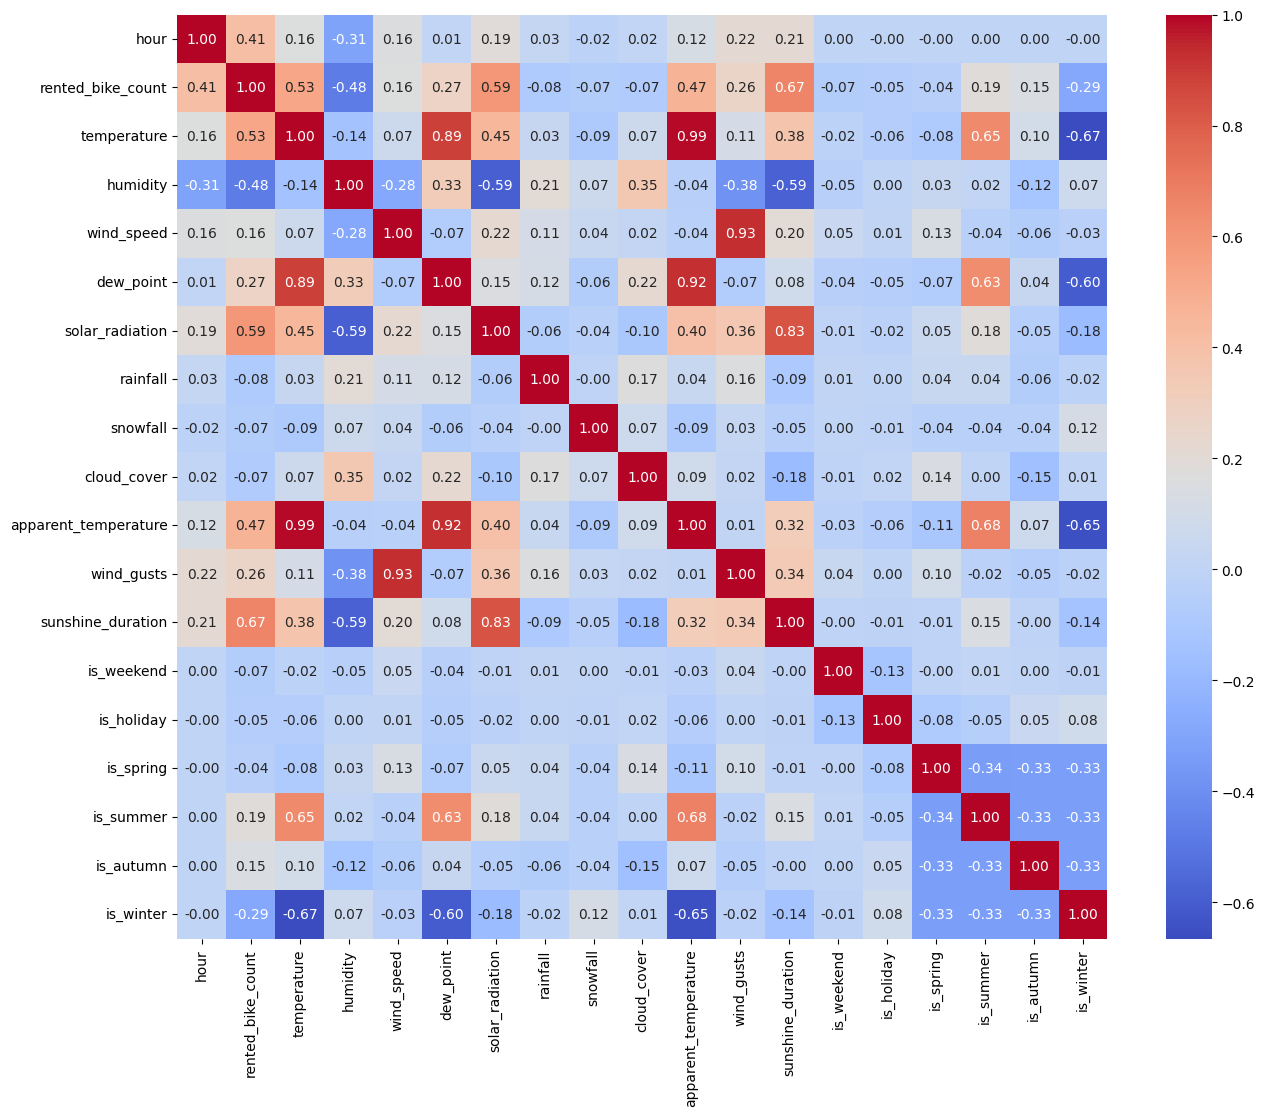

In [17]:
corr_matrix = data.drop(columns=['date']).corr()
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

<div class="alert alert-block alert-info">
As we can see from the correlation matrix above, there are several pairs of features that show strong correlations. For example, temperature and apparent_temperature are almost perfectly correlated (correlation coefficient ≈ 0.99), which is expected since apparent temperature is derived from actual temperature and other weather factors. Similarly, temperature and dew_point (0.89), wind_speed and wind_gusts (0.93) as well as sunshine_duration and solar_radiation (0.83), show high positive correlations. There are also notable negative correlations, such as between temperature and is_winter (-0.67), and sunshine_duration and humidity (-0.59).

Correlation measures the strength and direction of a linear relationship between two variables. Values close to 1 or -1 indicate a strong positive or negative linear relationship, respectively, while values near 0 suggest little to no linear association.

However, I have decided not to remove features with high correlation at this stage. This is because part of the analysis aims to study their individual and combined effects on bike rental demand, as well as to explore how different algorithms handle correlated predictors during model development and feature importance analysis. Retaining these features also allows for a more comprehensive ablation study in later stages.

Additionally, the machine learning models chosen for the next steps (Decision Tree and Random Forest) are robust to multicollinearity and can effectively handle correlated features without degrading performance.
</div>

In [18]:
data_non_cat = data.drop(['date', 'is_weekend', 'is_holiday', 'is_summer', 'is_winter', 'is_spring', 'is_autumn'], axis=1)

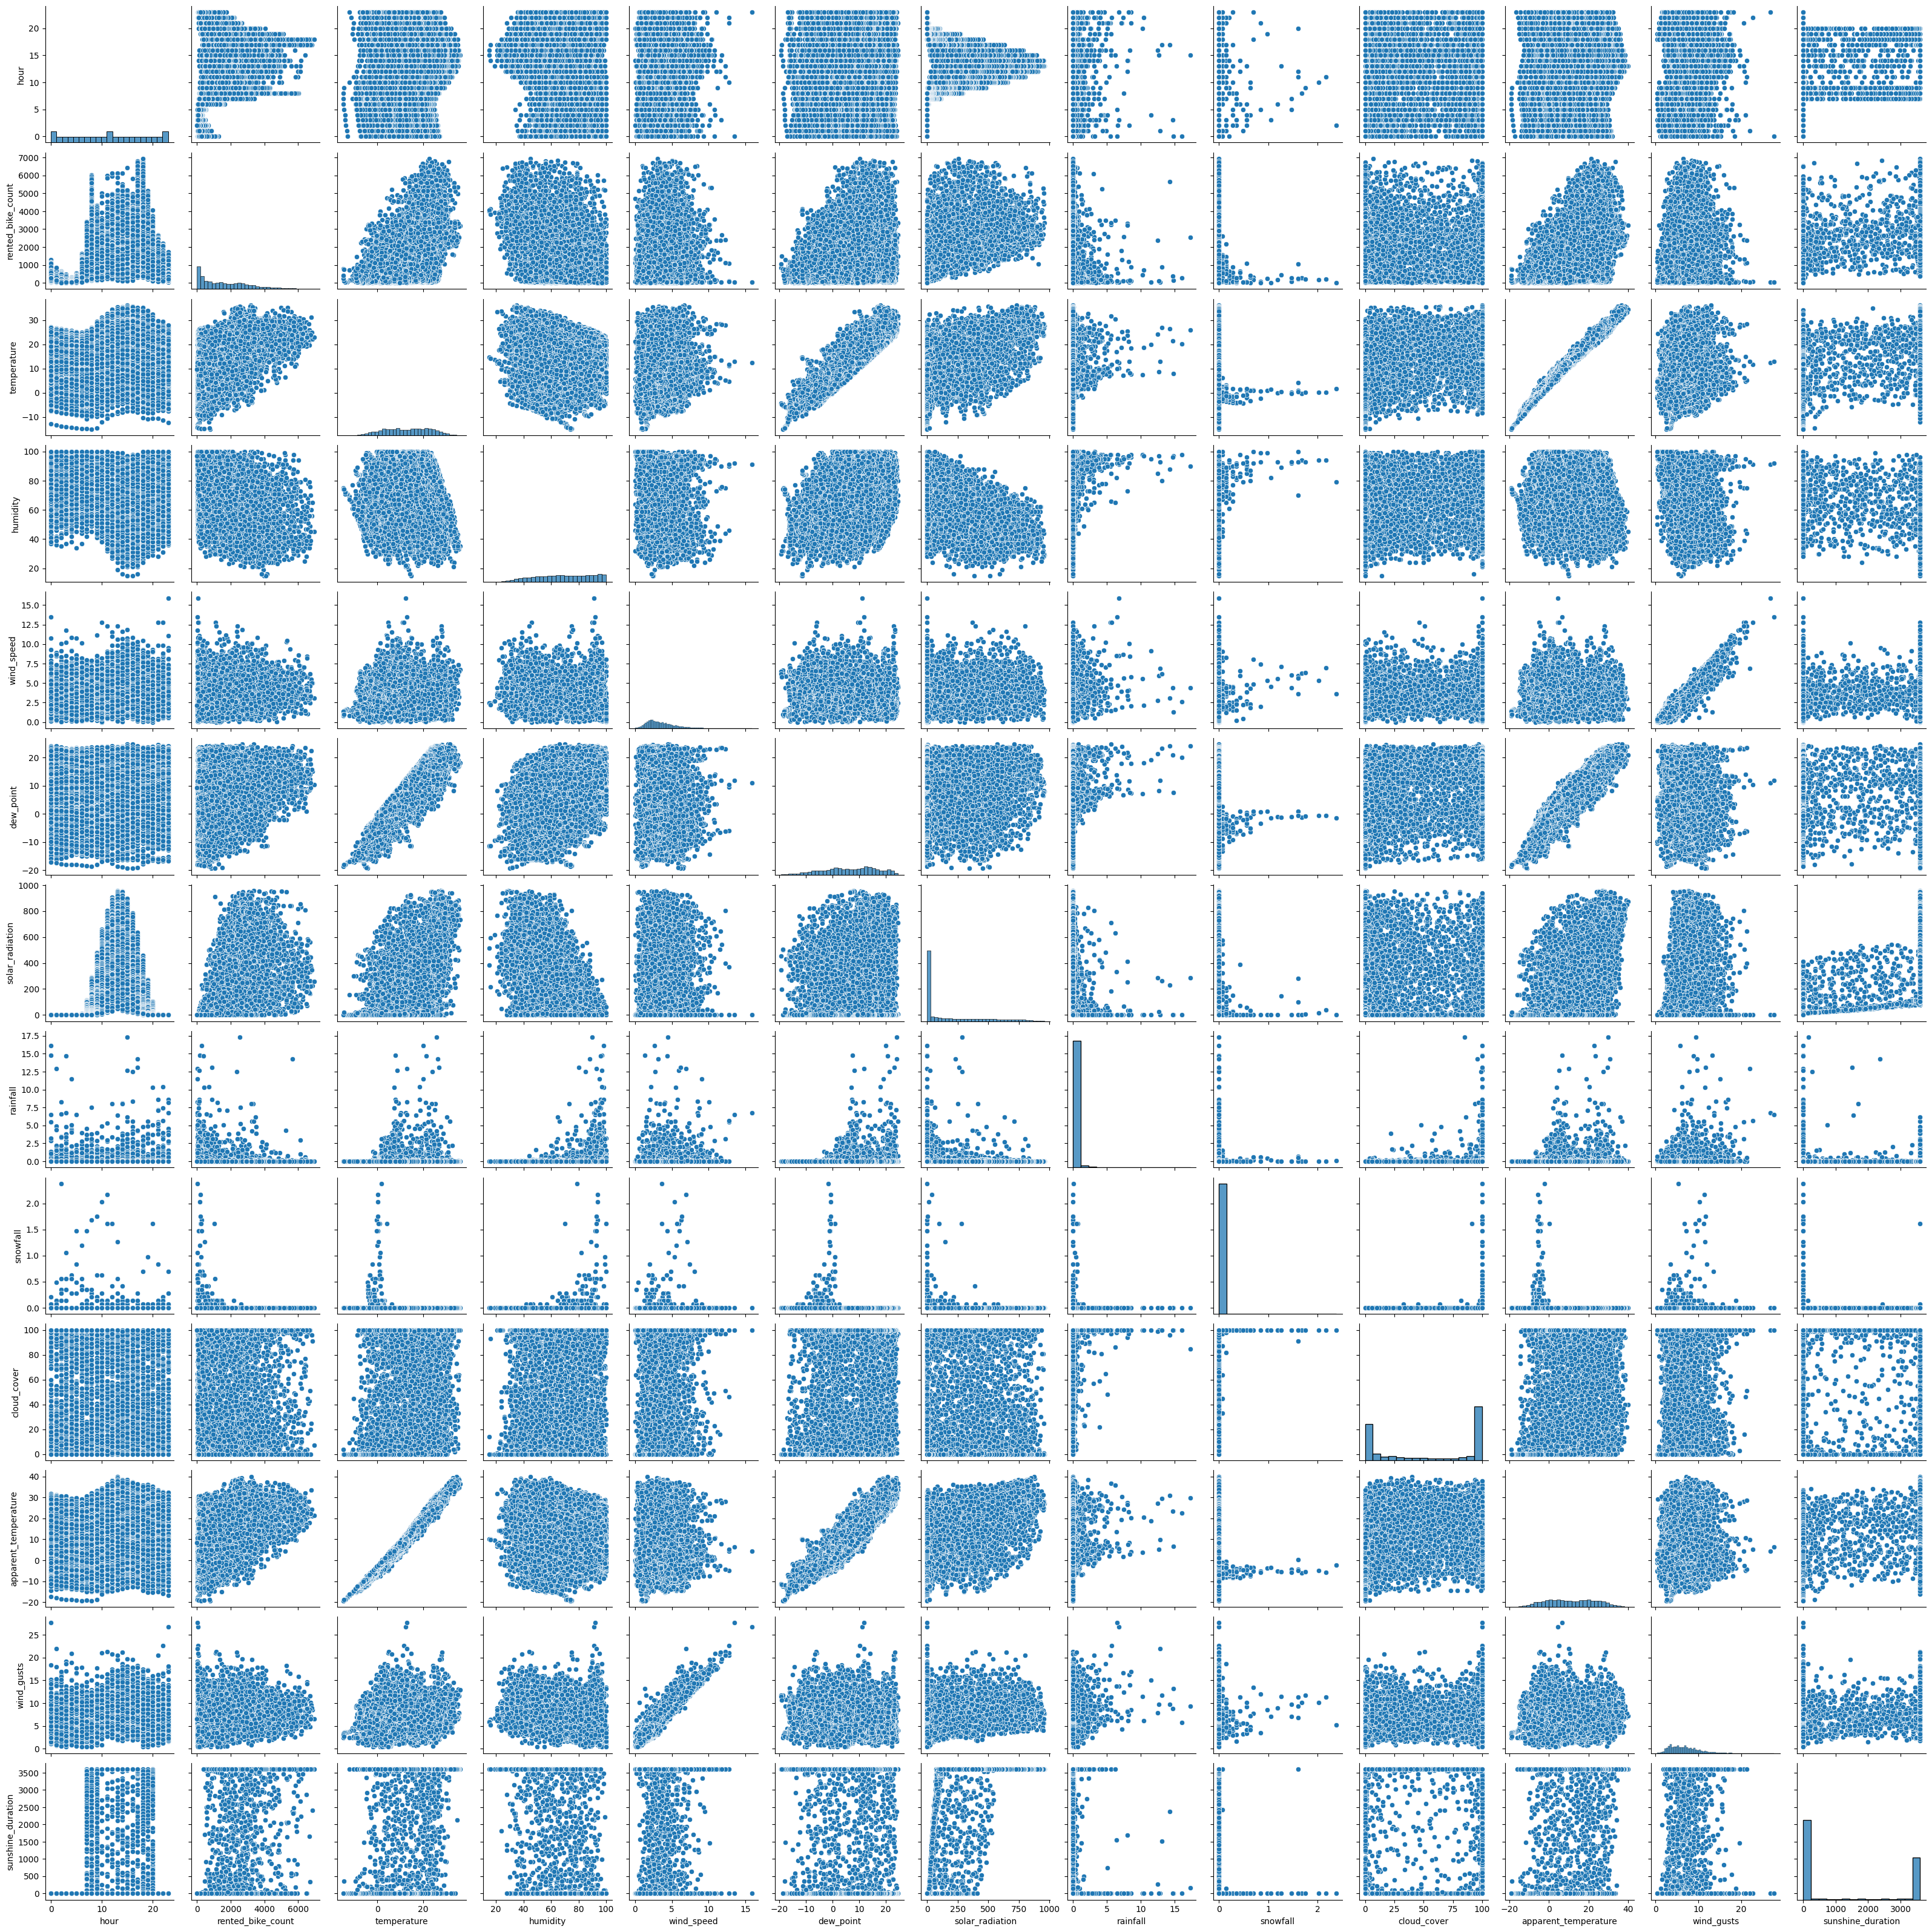

In [19]:
sns.pairplot(data_non_cat)

<div class="alert alert-block alert-info">

The pairplot above provides a comprehensive overview of the relationships and distributions among the main features in the dataset. Several clear patterns are:

- **Linear relationships**: Strong linear associations are visible between some feature pairs, such as between temperature and apparent temperature, and between temperature and dew point. These relationships are consistent with the high correlations observed earlier.

- **Target variable patterns**: The distribution of rented_bike_count appears right-skewed, indicating that high rental counts are less frequent. The scatterplots show that higher bike rental demand tends to occur at moderate to higher temperatures and lower humidity, suggesting that favorable weather boosts usage.

- **Normal distribution patterns**: Notably, the relationship between solar radiation and hour exhibits a daily cyclical pattern resembling a bell-shaped curve, with solar radiation peaking around midday and dropping to zero during nighttime hours. This reflects the natural daily cycle of sunlight.

- **Outliers and nonlinearities**: Some plots reveal potential outliers or nonlinear relationships, particularly for weather variables such as rainfall and wind speed, which may have threshold effects on bike rentals.

These insights will inform subsequent model selection in the next chapter.
</div>

# 5. First Impressions

<div class="alert alert-block alert-info">

For the experiments, I chose Decision Tree (DT) and Random Forest (RF) models due to the following reasons:

- **Ability to capture complex relationships**: Both DT and RF are capable of modeling nonlinear relationships and complex interactions between features, which are evident in the dataset based on the exploratory analysis.

- **Robustness to correlated features**: Random Forests, in particular, are robust to multicollinearity and can effectively manage correlated predictors without significant loss in performance.

- **Interpretability**: Decision Trees provide clear insights into feature importance and decision rules, which aids in understanding the key drivers of bike rental demand.

- **Empirical evidence**: Previous study has shown that ensemble models like Random Forest often outperform single models for bike rental demand prediction tasks, providing strong predictive performance and generalization (see Sathishkumar et al., "Using data mining techniques for bike sharing demand prediction in metropolitan city," Department of Information and Communication Engineering, Sunchon National University, South Korea).

</div>

In [20]:
from sklearn.metrics import mean_absolute_error, r2_score

<div class="alert alert-block alert-info">

In addition, it is worth noting that Decision Tree and Random Forest models do not require feature scaling. This is because their tree-based structure splits data according to feature thresholds, rather than relying on distance metrics as many other algorithms do. As a result, we can proceed with modeling without the need for additional preprocessing steps such as normalization or standardization. The only necessary step before model training is to split the data into training and test sets.

</div>

## 5.1. Split data

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X = data.drop(['rented_bike_count', 'date'], axis=1) # date is not part of the features
y = data['rented_bike_count']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

## 5.2. Experiment 1: Model with default parametrization

### 5.2.1. B: Simple Heuristic: Hourly Average

<div class="alert alert-block alert-info">

As a baseline, I implemented a simple heuristic that predicts the hourly average number of bike rentals for each hour of the day, calculated from the training data. For every test sample, the model predicts the mean number of rentals observed historically at the corresponding hour within one year period, regardless of other factors such as weather or calendar effects.

This approach is actually being used in practice by Citi Bike for operational forecasting and planning. 

Evaluating this baseline provides a meaningful reference point for the performance of more sophisticated machine learning models. Any model that significantly outperforms this heuristic demonstrates clear added value over the operational standard currently used by Citi Bike.

</div>

In [24]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [25]:
hourly_avg = train_df.groupby('hour')['rented_bike_count'].mean().reset_index()
hourly_avg.rename(columns={'rented_bike_count': 'hourly_avg'}, inplace=True)

test_df_with_hourly_avg = pd.merge(test_df, hourly_avg, on='hour', how='left')
y_pred_baseline_test = test_df_with_hourly_avg['hourly_avg'].values
mae_baseline_test = mean_absolute_error(test_df['rented_bike_count'], y_pred_baseline_test)
r2_baseline_test = r2_score(test_df['rented_bike_count'], y_pred_baseline_test)

train_df_with_hourly_avg = pd.merge(train_df, hourly_avg, on='hour', how='left')
y_pred_baseline_train = train_df_with_hourly_avg['hourly_avg'].values
mae_baseline_train = mean_absolute_error(train_df['rented_bike_count'], y_pred_baseline_train)
r2_baseline_train = r2_score(train_df['rented_bike_count'], y_pred_baseline_train)

### 5.2.2. A<sub>1</sub>: Decision Tree

In [26]:
from sklearn.tree import DecisionTreeRegressor

In [27]:
dt = DecisionTreeRegressor(random_state=RANDOM_SEED)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [28]:
y_pred_dt_test = dt.predict(X_test)
mae_dt_test = mean_absolute_error(y_test, y_pred_dt_test)
r2_dt_test = r2_score(y_test, y_pred_dt_test)

y_pred_dt_train = dt.predict(X_train)
mae_dt_train = mean_absolute_error(y_train, y_pred_dt_train)
r2_dt_train = r2_score(y_train, y_pred_dt_train)

### 5.2.3. A<sub>2</sub>: Random Forest

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [31]:
y_pred_rf_test = rf.predict(X_test)
mae_rf_test = mean_absolute_error(y_test, y_pred_rf_test)
r2_rf_test = r2_score(y_test, y_pred_rf_test)

y_pred_rf_train = rf.predict(X_train)
mae_rf_train = mean_absolute_error(y_train, y_pred_rf_train)
r2_rf_train = r2_score(y_train, y_pred_rf_train)

### 5.2.4. Result Comparision 1

In [32]:
baseline_results = {
    'Hourly Average Baseline - B': {
        'mae_train': mae_baseline_train, 'mae_test': mae_baseline_test,
        'r2_train': r2_baseline_train, 'r2_test': r2_baseline_test
    }
}

default_models_results = {
    'Decision Tree (default) - A₁': {
        'mae_train': mae_dt_train, 'mae_test': mae_dt_test,
        'r2_train': r2_dt_train, 'r2_test': r2_dt_test
    },
    'Random Forest (default) - A₂': {
        'mae_train': mae_rf_train, 'mae_test': mae_rf_test,
        'r2_train': r2_rf_train, 'r2_test': r2_rf_test
    }
}

In [33]:
model_results_1 = {**baseline_results, **default_models_results}

baseline = ['Hourly Average Baseline - B']
default_models = ['Decision Tree (default) - A₁', 'Random Forest (default) - A₂']
model_group_1 = [baseline, default_models]

display_model_results_table(model_results_1, mae_baseline_test, r2_baseline_test, model_group_1)

Model                               Train MAE     Test MAE     ΔMAE (Test)     Train R²      Test R²      ΔR² (Test)
Hourly Average Baseline - B               668          672          -0.0 %        0.593        0.576           0.0 %
--------------------------------------------------------------------------------------------------------------------
Decision Tree (default) - A₁                0          318          52.7 %        1.000        0.869          50.8 %
Random Forest (default) - A₂               88          241          64.2 %        0.990        0.928          61.1 %


<div class="alert alert-block alert-info">

The results demonstrate a clear performance improvement when moving from the simple hourly average baseline to more advanced machine learning models:

- **Baseline Model (Hourly Average)**: The baseline achieves a mean absolute error (MAE) of 668 on the training set and 672 on the test set, with R² values of 0.593 (train) and 0.576 (test). This confirms that the hourly average heuristic provides a reasonable starting point, capturing a moderate proportion of the variance in bike rental demand.

- **Decision Tree (A₁)**: The Decision Tree model fits the training data perfectly (MAE: 0, R²: 1.000), but its test MAE drops to 318 and test R² to 0.869. This represents a 52.7% reduction in test MAE and a 50.8% increase in test R² compared to the baseline. The large gap between training and test performance suggests some degree of overfitting, but the model still generalizes substantially better than the baseline.

- **Random Forest (A₂)**: The Random Forest model further improves predictive accuracy, with a train MAE of 88 and a test MAE of 241. The test R² increases to 0.928, representing a 64.2% reduction in MAE and a 61.1% improvement in R² over the baseline. The smaller gap between training and test scores indicates better generalization and robustness compared to the single decision tree.

</div>

## 5.3. Experiment 2: Simple cross validation

<div class="alert alert-block alert-info">

To obtain a more reliable estimate of model performance and to guard against overfitting, I used 10-fold cross-validation for both the Decision Tree and Random Forest models. In this approach, the dataset is split into ten equal parts (folds). Each model is trained on nine folds and validated on the remaining one, repeating this process so that every fold serves as the validation set once. The performance metrics MAE and R² scor —are then averaged across all folds to provide a robust assessment.

This method not only yields more stable and generalizable performance estimates than a single train-test split, but also allows us to observe the consistency of the models across different subsets of the data. The per-fold results offer insight into how much the model’s predictions vary depending on the specific data used for training and validation.

By comparing the cross-validation scores for both Decision Tree and Random Forest, we can better understand their generalization ability and identify which model is likely to perform best on unseen data.

</div>

### 5.3.1. Set up experiment for both models

In [34]:
from sklearn.model_selection import cross_validate

In [35]:
dt = DecisionTreeRegressor(random_state=RANDOM_SEED)
rf = RandomForestRegressor(n_jobs=4, random_state=RANDOM_SEED)

In [36]:
dt_cv_results = cross_validate(dt, X, y, cv=10, 
                               scoring=['neg_mean_absolute_error', 'r2'],
                               return_train_score=True)
rf_cv_results = cross_validate(rf, X, y, cv=10, 
                               scoring=['neg_mean_absolute_error', 'r2'],
                               return_train_score=True)

In [37]:
print(f"Model A1: Decision Tree - simple CV")
print(f"MAE: {-dt_cv_results['test_neg_mean_absolute_error'].mean():.0f}")
print("MAE per fold:", [f"{-mae:.0f}" for mae in dt_cv_results['test_neg_mean_absolute_error']])
print(f"R²: {dt_cv_results['test_r2'].mean():.3f}")
print("R² per fold:", [f"{r2:.3f}" for r2 in dt_cv_results['test_r2']])

Model A1: Decision Tree - simple CV
MAE: 377
MAE per fold: ['294', '317', '339', '435', '418', '418', '378', '427', '374', '368']
R²: 0.756
R² per fold: ['0.650', '0.708', '0.774', '0.793', '0.836', '0.805', '0.858', '0.807', '0.826', '0.507']


In [38]:
print(f"Model A2: Random Forest - simple CV")
print(f"MAE: {-rf_cv_results['test_neg_mean_absolute_error'].mean():.0f}")
print("MAE per fold:", [f"{-mae:.0f}" for mae in rf_cv_results['test_neg_mean_absolute_error']])
print(f"R²: {rf_cv_results['test_r2'].mean():.3f}")
print("R² per fold:", [f"{r2:.3f}" for r2 in rf_cv_results['test_r2']])

Model A2: Random Forest - simple CV
MAE: 280
MAE per fold: ['189', '228', '244', '292', '317', '330', '280', '323', '282', '315']
R²: 0.869
R² per fold: ['0.861', '0.862', '0.892', '0.909', '0.917', '0.874', '0.918', '0.907', '0.903', '0.644']


### 5.3.2. Result Comparision 2

In [39]:
cv_models_results = {
    'Decision Tree (simple CV) - A₁': {
        'mae_train': -dt_cv_results['train_neg_mean_absolute_error'].mean(), 
        'mae_test': -dt_cv_results['test_neg_mean_absolute_error'].mean(),
        'r2_train': dt_cv_results['train_r2'].mean(), 
        'r2_test': dt_cv_results['test_r2'].mean()
    },
    'Random Forest (simple CV) - A₂': {
        'mae_train': -rf_cv_results['train_neg_mean_absolute_error'].mean(), 
        'mae_test': -rf_cv_results['test_neg_mean_absolute_error'].mean(),
        'r2_train': rf_cv_results['train_r2'].mean(), 
        'r2_test': rf_cv_results['test_r2'].mean()
    }
}

In [40]:
model_results_2 = {**baseline_results, **default_models_results, **cv_models_results}

cv_models = ['Decision Tree (simple CV) - A₁', 'Random Forest (simple CV) - A₂']
model_group_2 = [baseline, default_models, cv_models]

display_model_results_table(model_results_2, mae_baseline_test, r2_baseline_test, model_group_2)

Model                               Train MAE     Test MAE     ΔMAE (Test)     Train R²      Test R²      ΔR² (Test)
Hourly Average Baseline - B               668          672          -0.0 %        0.593        0.576           0.0 %
--------------------------------------------------------------------------------------------------------------------
Decision Tree (default) - A₁                0          318          52.7 %        1.000        0.869          50.8 %
Random Forest (default) - A₂               88          241          64.2 %        0.990        0.928          61.1 %
--------------------------------------------------------------------------------------------------------------------
Decision Tree (simple CV) - A₁             -0          377          43.9 %        1.000        0.756          31.3 %
Random Forest (simple CV) - A₂             85          280          58.3 %        0.991        0.869          50.8 %


<div class="alert alert-block alert-info">

* Overfitting:

Both the Decision Tree and Random Forest models display some degree of overfitting, as indicated by their much better performance on the training data compared to the validation folds in both MAE and R² metrics. This effect is especially pronounced for the Decision Tree, which achieves a perfect MAE of 0 and R² of 1.00 on the training set, but shows considerably higher MAE (up to 435) and lower R² scores (down to 0.507) during cross-validation. This variability in fold performance, particularly the lower R² in one fold, suggests the Decision Tree's sensitivity to specific data splits or the presence of challenging subsets within the data. This is typical for unconstrained decision trees, as they can grow very deep to perfectly fit the training data, including noise, which harms their ability to generalize to unseen data. While the Random Forest also performs better on training data, its validation MAE and R² are much closer to its training performance, indicating better generalization. The ensemble nature of Random Forests, by averaging predictions from multiple trees trained on bootstrapped samples, inherently reduces variance and makes them more robust to overfitting compared to single decision trees. Overall, overfitting is present in both models, but it is a more significant issue for the Decision Tree, as seen in both error and explained variance.

* Quality:

Despite the drop in performance from the single train-test split to cross-validation, both Decision Tree and Random Forest models with simple CV still achieve much better results than the baseline hourly average. The Random Forest, in particular, achieves a mean MAE of 280 and a mean R² of 0.869 across folds, substantially outperforming the baseline (MAE: 672, R²: 0.576). This demonstrates that both models, and especially the ensemble approach, provide high-quality predictions that capture meaningful patterns in the data.

* Stability:

The Random Forest model exhibits strong stability, with MAE per fold ranging from 189 to 330 and R² scores consistently high (mostly 0.861 – 0.918, with only one fold at 0.644). This indicates that its performance is robust to different training and validation splits, making it reliable for real-world deployment. In contrast, the Decision Tree shows more fluctuation across folds, reflecting lower stability and higher sensitivity to data variability.

</div>

# 6. Hyperparameter Optimization - Nested Cross Validation

## 6.1. Experiment 3

<div class="alert alert-block alert-info">

In this step, I used nested cross-validation to tune hyperparameters and evaluate both the Decision Tree and Random Forest models. I set up pipelines and defined grids of parameters to search over. For each model, a 5-fold inner cross-validation was used for hyperparameter tuning with GridSearchCV, while a 10-fold outer cross-validation estimated generalization performance. The 10-fold outer CV was chosen to reuse the splits established in the previous cross-validation experiment, while the 5-fold inner CV balanced computational efficiency with robust hyperparameter search. This approach ensures unbiased model selection and performance assessment, and reports the optimal parameters and metrics for each fold.

</div>

In [41]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline

In [42]:
dt_pipe = Pipeline([('regressor', DecisionTreeRegressor(random_state=RANDOM_SEED))])
rf_pipe = Pipeline([('regressor', RandomForestRegressor(n_jobs=4, random_state=RANDOM_SEED))])

In [43]:
dt_param_grid = {
    'regressor__max_depth': [None, 5, 10, 15],
    'regressor__min_samples_split': [2, 5, 10, 20],
    'regressor__min_samples_leaf': [1, 2, 4, 8],
    'regressor__max_features': ['sqrt', None, 0.5, 1],
}

rf_param_grid = {
    'regressor__n_estimators': [100, 200, 300, 500],
    'regressor__max_depth': [None, 10],
    'regressor__max_features': [None, 0.5],  
}

In [44]:
outer_cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [45]:
dt_grid = GridSearchCV(dt_pipe, dt_param_grid, cv=inner_cv, n_jobs=4, 
                       scoring=['neg_mean_absolute_error', 'r2'], 
                       refit='neg_mean_absolute_error')

In [46]:
rf_grid = GridSearchCV(rf_pipe, rf_param_grid, cv=inner_cv, n_jobs=4, 
                      scoring=['neg_mean_absolute_error', 'r2'], 
                      refit='neg_mean_absolute_error')

In [47]:
dt_nested_results = cross_validate(dt_grid, X, y, cv=outer_cv, n_jobs=4,
                                   scoring=['neg_mean_absolute_error', 'r2'],
                                   return_estimator=True, return_train_score=True)

In [48]:
print("Decision Tree - Best parameters per fold:")
for i, estimator in enumerate(dt_nested_results['estimator']):
    print(f"Fold {i+1}: {estimator.best_params_}")

Decision Tree - Best parameters per fold:
Fold 1: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 20}
Fold 2: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 20}
Fold 3: {'regressor__max_depth': 15, 'regressor__max_features': None, 'regressor__min_samples_leaf': 8, 'regressor__min_samples_split': 2}
Fold 4: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 8, 'regressor__min_samples_split': 20}
Fold 5: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 20}
Fold 6: {'regressor__max_depth': 15, 'regressor__max_features': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 20}
Fold 7: {'regressor__max_depth': 15, 'regressor__max_features': None, 'regressor__min_samples_leaf': 2, 'regres

In [49]:
print(f"Model A1: Decision Tree - Nested CV")
print(f"MAE: {-dt_nested_results['test_neg_mean_absolute_error'].mean():.0f}")
print("MAE per fold:", [f"{-mae:.0f}" for mae in dt_nested_results['test_neg_mean_absolute_error']])
print(f"R²: {dt_nested_results['test_r2'].mean():.3f}")
print("R² per fold:", [f"{r2:.3f}" for r2 in dt_nested_results['test_r2']])

Model A1: Decision Tree - Nested CV
MAE: 291
MAE per fold: ['282', '315', '271', '287', '297', '287', '290', '283', '308', '292']
R²: 0.892
R² per fold: ['0.888', '0.874', '0.905', '0.900', '0.885', '0.912', '0.887', '0.895', '0.890', '0.884']


In [50]:
rf_nested_results = cross_validate(rf_grid, X, y, cv=outer_cv, n_jobs=4, 
                                  scoring=['neg_mean_absolute_error', 'r2'],
                                  return_estimator=True, return_train_score=True)

In [51]:
print("\nRandom Forest - Best parameters per fold:")
for i, estimator in enumerate(rf_nested_results['estimator']):
    print(f"Fold {i+1}: {estimator.best_params_}")


Random Forest - Best parameters per fold:
Fold 1: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__n_estimators': 500}
Fold 2: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__n_estimators': 500}
Fold 3: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__n_estimators': 500}
Fold 4: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__n_estimators': 500}
Fold 5: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__n_estimators': 500}
Fold 6: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__n_estimators': 500}
Fold 7: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__n_estimators': 500}
Fold 8: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__n_estimators': 300}
Fold 9: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__n_estimators': 500}
Fold 10: {'regressor_

<div class="alert alert-block alert-info">

Notably, the optimal hyperparameters for the Random Forest model were consistent across all 10 outer folds (except for Fold 9), indicating a robust and stable hyperparameter selection.
</div>

In [52]:
print(f"Model A2: Random Forest - Nested CV")
print(f"MAE: {-rf_nested_results['test_neg_mean_absolute_error'].mean():.0f}")
print("MAE per fold:", [f"{-mae:.0f}" for mae in rf_nested_results['test_neg_mean_absolute_error']])
print(f"R²: {rf_nested_results['test_r2'].mean():.3f}")
print("R² per fold:", [f"{r2:.3f}" for r2 in rf_nested_results['test_r2']])

Model A2: Random Forest - Nested CV
MAE: 232
MAE per fold: ['228', '247', '213', '230', '232', '233', '240', '226', '244', '231']
R²: 0.932
R² per fold: ['0.933', '0.928', '0.944', '0.935', '0.927', '0.938', '0.927', '0.935', '0.931', '0.927']


In [53]:
nested_dt_mae_train = -dt_nested_results['train_neg_mean_absolute_error'].mean()
nested_dt_mae_test = -dt_nested_results['test_neg_mean_absolute_error'].mean()
nested_dt_r2_train = dt_nested_results['train_r2'].mean()
nested_dt_r2_test = dt_nested_results['test_r2'].mean()

nested_rf_mae_train = -rf_nested_results['train_neg_mean_absolute_error'].mean()
nested_rf_mae_test = -rf_nested_results['test_neg_mean_absolute_error'].mean()
nested_rf_r2_train = rf_nested_results['train_r2'].mean()
nested_rf_r2_test = rf_nested_results['test_r2'].mean()

## 6.2. Result Comparision 3

In [54]:
nested_cv_models_results = {
    'Decision Tree (nested CV) - A₁': {
        'mae_train': nested_dt_mae_train, 'mae_test': nested_dt_mae_test,
        'r2_train': nested_dt_r2_train, 'r2_test': nested_dt_r2_test
    },
    'Random Forest (nested CV) - A₂': {
        'mae_train': nested_rf_mae_train, 'mae_test': nested_rf_mae_test,
        'r2_train': nested_rf_r2_train, 'r2_test': nested_rf_r2_test
    }
}

In [55]:
model_results_3 = {**baseline_results, **default_models_results, **cv_models_results, **nested_cv_models_results}

nested_cv_models = ['Decision Tree (nested CV) - A₁', 'Random Forest (nested CV) - A₂']
model_group_3 = [baseline, default_models, cv_models, nested_cv_models]

display_model_results_table(model_results_3, mae_baseline_test, r2_baseline_test, model_group_3)

Model                               Train MAE     Test MAE     ΔMAE (Test)     Train R²      Test R²      ΔR² (Test)
Hourly Average Baseline - B               668          672          -0.0 %        0.593        0.576           0.0 %
--------------------------------------------------------------------------------------------------------------------
Decision Tree (default) - A₁                0          318          52.7 %        1.000        0.869          50.8 %
Random Forest (default) - A₂               88          241          64.2 %        0.990        0.928          61.1 %
--------------------------------------------------------------------------------------------------------------------
Decision Tree (simple CV) - A₁             -0          377          43.9 %        1.000        0.756          31.3 %
Random Forest (simple CV) - A₂             85          280          58.3 %        0.991        0.869          50.8 %
----------------------------------------------------------------

<div class="alert alert-block alert-info">

* Overfitting:

With the introduction of nested cross-validation, both Decision Tree and Random Forest models demonstrate an improved balance between training and validation performance. The Decision Tree’s training MAE rises to 191 and its R² drops to 0.954, while its test MAE is 291 and test R² is 0.892. This is a notable shift from the default split, where the model fit the training data perfectly (MAE: 0, R²: 1.00) but performed much worse on unseen data, indicating severe overfitting. Nested CV provides a more realistic estimate of generalization error by tuning hyperparameters within each fold, reducing the risk of overfitting to specific data splits. The Random Forest doesn't show increase in train MAE and maintains a high train R² (0.991), but its test MAE improves to 232 and test R² to 0.932. This suggests that nested CV helps both models, especially the Decision Tree, to generalize better and avoid overfitting, while Random Forest continues to show strong generalization.

* Quality:

Comparing the final performance estimates, both models achieve their best test results with nested cross-validation. The Random Forest, in particular, achieves a test MAE of 232 and R² of 0.932, outperforming its default split (test MAE: 241, R²: 0.928) and simple CV (test MAE: 280, R²: 0.869). The Decision Tree also improves compared to simple CV (test MAE: 291 vs. 377, R²: 0.892 vs. 0.756). Most importantly, both models are significantly better than the baseline (MAE: 672, R²: 0.576), confirming that advanced machine learning methods, especially ensemble models, provide high-quality, reliable predictions for bike rental demand. Nested CV ensures that these quality metrics are not inflated by overfitting or lucky splits, but reflect robust model performance.

* Stability:

Nested cross-validation enhances the stability of performance estimates by averaging results across multiple data splits and hyperparameter configurations. The Random Forest’s MAE per fold is tightly clustered (213 to 247), and its R² per fold is remarkably consistent (all around 0.928 - 0.944), demonstrating excellent stability and reliability. The Decision Tree also shows improved consistency across folds compared to simple CV, with less fluctuation in both MAE and R². This increased stability is crucial for real-world deployment, as it indicates that the models' predictions will be less sensitive to variations in the data and more trustworthy in practice.

* Summary:

Nested cross-validation not only provides a more honest and unbiased assessment of model performance, but also leads to better generalization, higher predictive quality, and greater stability compared to both simple cross-validation and single train-test splits. These improvements are most pronounced for the Decision Tree, which benefits from hyperparameter tuning, but are also evident for the Random Forest, which achieves state-of-the-art performance and robustness for this regression task. Both models remain far superior to the operational baseline, validating their use for Citi Bike demand prediction.

</div>

## 6.3. Final Model M

<div class="alert alert-block alert-info">

Based on the results of the nested cross-validation, I recommend selecting the Random Forest model as the final algorithm for predicting hourly bike rental demand. It consistently outperformed both the Decision Tree and the baseline across all evaluation metrics, achieving the lowest MAE and the highest R² scores.

The optimal hyperparameters identified for the Random Forest were: n_estimators=500, max_depth=None, and max_features=None. This configuration provided the best balance between predictive accuracy and generalization. The average test performance across the outer folds of the nested cross-validation, which provides the most unbiased estimate of this model's generalization capability, yielded an average test MAE of 232 and an average test R² of 0.932.

</div>

<div class="alert alert-block alert-info">

After determining the optimal hyperparameters via nested cross-validation, the final Random Forest model is trained on the entire dataset (X, y) to maximize its learning from all available data. This model instance will be used for the subsequent feature importance and ablation studies, and represents the model ready for potential operational deployment.

</div>

In [56]:
# Since we confirmed the best hyperparameters are consistent across folds for RF, picking the first is fine
best_params = rf_nested_results['estimator'][0].best_params_

In [57]:
final_model_rf = Pipeline([
    ('regressor', RandomForestRegressor(n_jobs=4, random_state=RANDOM_SEED))
])
final_model_rf.set_params(**best_params)

Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_features=None, n_estimators=500,
                                       n_jobs=4, random_state=42))])

In [58]:
final_model_rf.fit(X, y)

Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_features=None, n_estimators=500,
                                       n_jobs=4, random_state=42))])

<div class="alert alert-block alert-info">

We observed that several features are correlated with each other, and training models on many features increases computational time without necessarily improving prediction quality. For this reason, in the next section, we will analyze feature importance and perform feature ablation studies to identify which features truly contribute to model performance.

</div>

# 7. Feature Importance / Feature Ablation Study 

In [59]:
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin

In [60]:
class FeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_remove=None):
        self.features_to_remove = features_to_remove
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.features_to_remove is not None and len(self.features_to_remove) > 0:
            return X.drop(columns=self.features_to_remove, errors='ignore')
        return X

## 7.1. Feature Importance

<div class="alert alert-block alert-info">

In this step, I assessed the importance of each feature using the permutation importance method on the final Random Forest model. This technique measures how much the model’s performance metrics increase when the values of each feature are randomly shuffled, thereby breaking the relationship between that feature and the target variable.

By repeating this process 10 times for each feature, I obtained both the average and standard deviation of the importance scores, which indicate how much each feature contributes to the model’s predictive accuracy. The results were then sorted and visualized in a bar plot, allowing for a clear comparison of which features have the greatest impact on model performance. This analysis helps identify the most influential predictors and guides further feature selection or ablation steps.

</div>

In [61]:
perm_importance = permutation_importance(
    final_model_rf, X, y,
    n_repeats=10,
    random_state=RANDOM_SEED,
    scoring=['neg_mean_absolute_error', 'r2']
)

In [62]:
feature_importance_mae_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance['neg_mean_absolute_error']['importances_mean'],
    'importance_std': perm_importance['neg_mean_absolute_error']['importances_std']
}).sort_values('importance_mean', ascending=False)

In [63]:
print("Feature Importance Rankings for MAE:")
for idx, row in feature_importance_mae_df.iterrows():
    print(f"{row['feature']:20s}: {row['importance_mean']:.2f} ± {row['importance_std']:.2f}")

Feature Importance Rankings for MAE:
hour                : 800.22 ± 5.42
solar_radiation     : 554.56 ± 5.29
temperature         : 369.99 ± 3.70
is_weekend          : 237.62 ± 3.43
apparent_temperature: 117.40 ± 0.89
humidity            : 110.86 ± 1.93
is_autumn           : 68.28 ± 1.40
rainfall            : 53.24 ± 1.08
dew_point           : 48.89 ± 0.57
sunshine_duration   : 42.58 ± 0.56
wind_gusts          : 31.81 ± 0.64
wind_speed          : 31.19 ± 0.58
cloud_cover         : 29.90 ± 0.59
is_holiday          : 11.13 ± 0.80
is_spring           : 4.61 ± 0.15
is_winter           : 3.65 ± 0.17
snowfall            : 2.28 ± 0.09
is_summer           : 1.63 ± 0.07


In [64]:
feature_importance_r2_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance['r2']['importances_mean'],
    'importance_std': perm_importance['r2']['importances_std']
}).sort_values('importance_mean', ascending=False)

In [65]:
print("Feature Importance Rankings for R²:")
for idx, row in feature_importance_r2_df.iterrows():
    print(f"{row['feature']:20s}: {row['importance_mean']:.2f} ± {row['importance_std']:.2f}")

Feature Importance Rankings for R²:
hour                : 0.68 ± 0.01
solar_radiation     : 0.43 ± 0.01
temperature         : 0.27 ± 0.01
is_weekend          : 0.17 ± 0.01
humidity            : 0.05 ± 0.00
apparent_temperature: 0.03 ± 0.00
is_autumn           : 0.03 ± 0.00
rainfall            : 0.03 ± 0.00
dew_point           : 0.01 ± 0.00
sunshine_duration   : 0.01 ± 0.00
is_holiday          : 0.01 ± 0.00
wind_gusts          : 0.01 ± 0.00
wind_speed          : 0.01 ± 0.00
cloud_cover         : 0.01 ± 0.00
snowfall            : 0.00 ± 0.00
is_spring           : 0.00 ± 0.00
is_winter           : 0.00 ± 0.00
is_summer           : 0.00 ± 0.00


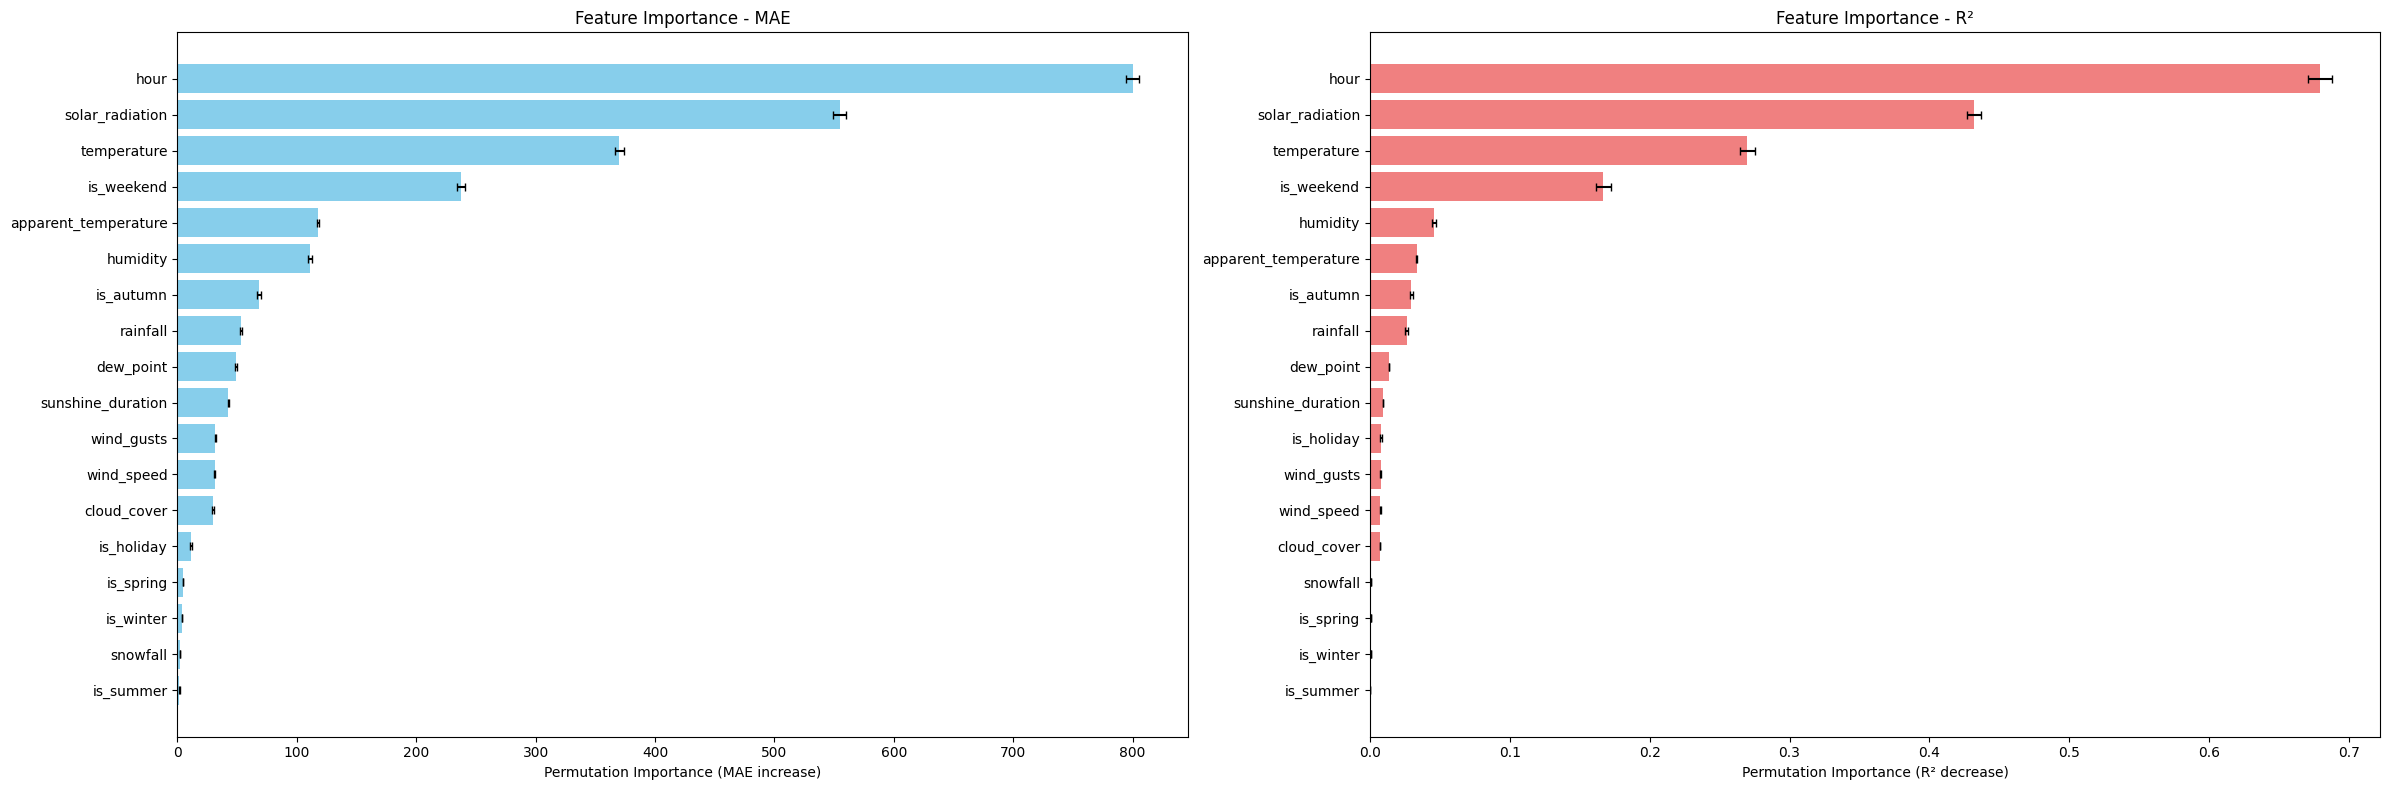

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

ax_mae = axes[0]
ax_mae.barh(range(len(feature_importance_mae_df)),
            feature_importance_mae_df['importance_mean'],
            xerr=feature_importance_mae_df['importance_std'], capsize=3, color='skyblue')
ax_mae.set_yticks(range(len(feature_importance_mae_df)))
ax_mae.set_yticklabels(feature_importance_mae_df['feature'])
ax_mae.set_xlabel('Permutation Importance (MAE increase)')
ax_mae.set_title('Feature Importance - MAE')
ax_mae.invert_yaxis()


ax_r2 = axes[1] 
ax_r2.barh(range(len(feature_importance_r2_df)),
           feature_importance_r2_df['importance_mean'],
           xerr=feature_importance_r2_df['importance_std'], capsize=3, color='lightcoral')
ax_r2.set_yticks(range(len(feature_importance_r2_df)))
ax_r2.set_yticklabels(feature_importance_r2_df['feature'])
ax_r2.set_xlabel('Permutation Importance (R² decrease)')
ax_r2.set_title('Feature Importance - R²')
ax_r2.invert_yaxis()

plt.tight_layout()

plt.show()

<div class="alert alert-block alert-info">

The permutation importance analysis reveals that the features hour, solar_radiation, and temperature have the greatest impact on the predictive performance of the final Random Forest model. Specifically, hour stands out as the most important feature, followed closely by solar_radiation, with both contributing substantially more than the remaining variables. This suggests that the time of day and the amount of sunlight are key drivers of hourly bike rental demand.

Conversely, features such as is_summer and snowfall show very low importance, indicating that their removal would likely have minimal effect on model accuracy.

For the next ablation study, I selected the two least important features is_summer and snowfall based on their consistently low permutation importance scores across both MAE and R² metrics. By removing these features and observing any changes in model performance, we can further validate their limited contribution and potentially simplify the model without sacrificing predictive quality.

</div>

## 7.2. Feature Ablation Study

In [67]:
least_important_features = feature_importance_mae_df.tail(2)['feature'].tolist()
F1, F2 = least_important_features[0], least_important_features[1]

print(f"Least important features selected for ablation:")
print(f"F1: {F1}")
print(f"F2: {F2}")

outer_cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

scenarios = {
    'Baseline (All Features)': [],
    f'Remove {F1}': [F1],
    f'Remove {F2}': [F2],
    f'Remove {F1} & {F2}': [F1, F2]
}

ablation_results = {}

Least important features selected for ablation:
F1: snowfall
F2: is_summer


In [68]:
for scenario_name, features_to_remove in scenarios.items():
    print(f"Testing: {scenario_name}")
    
    pipeline = Pipeline([
        ('feature_remover', FeatureRemover(features_to_remove)),
        ('regressor', final_model_rf)
    ])
    
    cv_results = cross_validate(
        pipeline, X, y, 
        cv=outer_cv,
        scoring=['neg_mean_absolute_error', 'r2'],
        return_train_score=True
    )
    
    ablation_results[scenario_name] = {
        'mae_mean': -cv_results['test_neg_mean_absolute_error'].mean(),
        'mae_std': cv_results['test_neg_mean_absolute_error'].std(),
        'r2_mean': cv_results['test_r2'].mean(),
        'r2_std': cv_results['test_r2'].std()
    }

Testing: Baseline (All Features)
Testing: Remove snowfall
Testing: Remove is_summer
Testing: Remove snowfall & is_summer


In [69]:
print(f"{'Scenario':<30} {'MAE':<20} {'R²':<20} {'ΔMAE':<15} {'ΔR²':<20}")
print("-" * 100)

baseline_mae = ablation_results['Baseline (All Features)']['mae_mean']
baseline_r2 = ablation_results['Baseline (All Features)']['r2_mean']

for scenario, results in ablation_results.items():
    mae_change = results['mae_mean'] - baseline_mae
    r2_change = results['r2_mean'] - baseline_r2
    change_symbol_mae = "+" if mae_change > 0 else (" " if mae_change == 0 else "")
    change_symbol_r2 = "+" if r2_change > 0 else (" " if r2_change == 0 else "")
    print(f"{scenario:<30} "
          f"{results['mae_mean']:.3f} ± {results['mae_std']:.3f}      " 
          f"{results['r2_mean']:.3f} ± {results['r2_std']:.3f}        "
          f"{change_symbol_mae}{mae_change:.3f}          "
          f"{change_symbol_r2}{r2_change:.3f}")

Scenario                       MAE                  R²                   ΔMAE            ΔR²                 
----------------------------------------------------------------------------------------------------
Baseline (All Features)        232.335 ± 9.102      0.932 ± 0.005         0.000           0.000
Remove snowfall                233.293 ± 9.096      0.932 ± 0.005        +0.958          -0.000
Remove is_summer               232.437 ± 9.095      0.932 ± 0.005        +0.103          -0.000
Remove snowfall & is_summer    233.278 ± 9.056      0.932 ± 0.005        +0.943          -0.000


<div class="alert alert-block alert-info">

The feature ablation study confirms that removing the least important features, snowfall and is_summer, has a negligible impact on model performance. When each feature is removed individually, the MAE and R² scores remain almost unchanged compared to the baseline scenario where all features are included. Specifically, removing snowfall increases the MAE by only 0.958 and no change in R², while removing is_summer actually results in a minimal decrease in MAE (0.103) and no change in R². 

Even when both features are removed simultaneously, the changes in MAE (0.943) are extremely small and well within the standard deviation of the baseline results. This demonstrates that these features contribute very little to the predictive power of the model, and can be safely excluded without any meaningful loss in accuracy or explained variance. This finding supports the results of the permutation importance analysis and highlights the potential for simplifying the model by removing irrelevant features.

</div>

# 8. Conclusions and Future Work

## 8.1. Summary and interpretation of results

<div class="alert alert-block alert-info">

This proof of concept demonstrates that machine learning models, especially Random Forests with optimized hyperparameters, can substantially improve the accuracy of hourly bike demand forecasting over traditional heuristic approaches. The selected model effectively captures the complex relationships between temporal, weather, and calendar features, providing a robust foundation for more responsive and data-driven operational planning at Citi Bike.

</div>

## 8.2. Generated value

<div class="alert alert-block alert-info">

Accurate demand forecasting delivers significant value to Citi Bike by enabling the company to:

* Optimize bike redistribution, reducing both shortages and surpluses, and thereby lowering operational costs.

* Enhance customer satisfaction by ensuring bike availability where and when it is needed most.

* Support dynamic pricing, targeted marketing, and resource allocation strategies, ultimately improving business outcomes.

The final model developed in this PoC can now be deployed and assessed in real-life operations to test its actual performance and impact, providing valuable feedback for further improvements.

</div>

## 8.3. Ideas for future work

<div class="alert alert-block alert-info">

* **Station-level or bike-type forecasts**: More granular predictions would enable targeted redistribution and operational efficiency.

* **Add more external data sources**: Incorporating real-time events, transit disruptions, or social media could improve responsiveness to sudden demand shifts.

* **Test advanced algorithms and hyperparameter optimization techniques**: While only Decision Tree and Random Forest were used in this study, exploring models like Gradient Boosting or Neural Networks could further boost accuracy. Additionally, investigating more advanced hyperparameter optimization methods such as RandomizedSearchCV (for more efficient exploration of large parameter spaces) or Bayesian Optimization could lead to even better model configurations. AutoML tools could also streamline broader model and hyperparameter comparisons.

* **Deploy and monitor in real time**: Implementing the model in production and tracking its impact on business KPIs would validate its practical value and guide ongoing improvements.

</div>

## 8.4. Critical discussion of methodology

<div class="alert alert-block alert-info">

The methodology adopted in this project aligns with best practices in machine learning, including robust nested cross-validation, systematic feature analysis, and careful model tuning. However, some limitations remain:

* Certain external factors influencing demand (such as local events or transit disruptions) were not included in the current dataset.

* The model assumes stationarity in demand patterns, which may not fully capture seasonality or long-term trends.

* Results are based on aggregated data. More granular insights could be obtained with station-level or real-time data.

Several additional remarks:

* While the pipelines used in cross-validation include the regressor, some feature engineering steps (e.g., creating is_weekend, is_holiday, and season flags) were performed on the entire dataset prior to splitting. This approach was chosen because these transformations are deterministic derivations from existing features and do not introduce data leakage, unlike transformations that learn parameters from the data (e.g., scaling or imputation), which would be strictly integrated into the pipeline.

* Regarding the influence of class imbalance, as this is a regression problem predicting a continuous count, the concept of class imbalance does not directly apply. The distribution of rented_bike_count was analyzed in the EDA, confirming a right-skewed distribution, which is common for count data and handled effectively by the chosen tree-based models without specific mitigation for 'imbalance'.

While the goals set for this PoC were realistic and achievable, operational deployment will require further validation, continuous improvement, and seamless integration with Citi Bike’s existing systems.
</div>